In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import *
import tqdm
import string
import random

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [2]:
### READ DATA ###

df = pd.read_csv('Uber_Ride_Reviews.csv')

print(df.shape)
df.head()

(1344, 3)


,ride_review,ride_rating,sentiment
0,I completed running New York Marathon requeste...,1.0,0
1,My appointment time auto repairs required earl...,1.0,0
2,Whether I using Uber ride service Uber Eats or...,1.0,0
3,Why hard understand I trying retrieve Uber cab...,1.0,0
4,I South Beach FL I staying major hotel ordered...,1.0,0


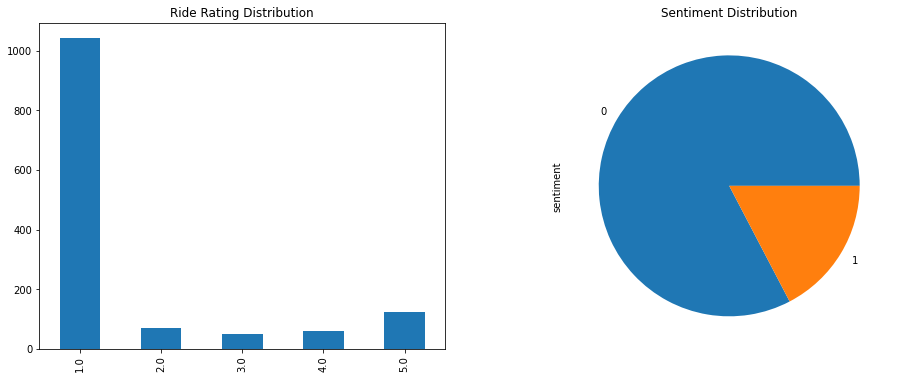

In [3]:
### LABEL DISTRIBUTION ###

plt.figure(figsize=(16,6))

plt.subplot(121)
df.ride_rating.value_counts().sort_index().plot.bar(title='Ride Rating Distribution')

plt.subplot(122)
df.sentiment.value_counts().plot.pie(title='Sentiment Distribution')

In [4]:
### REMOVE 3 STARS REVIEWS ###

df = df.loc[df.ride_rating!=3, :].reset_index(drop=True)

In [5]:
### CLEAN TEXT (NOT REQUIRED) ###

df['text'] = df.ride_review.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')

In [6]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['sentiment'].values, 
                                                    random_state = 42, test_size=0.2)

In [7]:
### CREATE FEATURES WITH TFIDF ###

stop = set(stopwords.words('english'))
tfidf = TfidfVectorizer(min_df=3, stop_words=stop)
tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=3, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [8]:
### REVIEWS LENGTH DISTRIBUTION ON TRAIN ###

c = Counter([len(s.split()) for s in X_train])
lenghts = np.asarray(list(c.keys()))
freq = np.asarray(list(c.values()))
freq = freq/freq.sum()

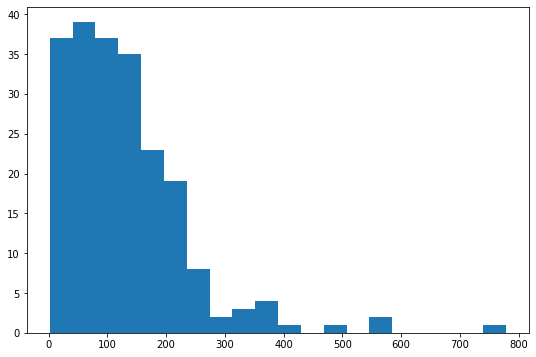

In [9]:
### PLOT REVIEWS LENGTH DISTRIBUTION ON TRAIN ###

plt.figure(figsize=(9,6))
plt.hist(lenghts, bins=20)
np.set_printoptions(False)

In [10]:
### DEFINE MARKOV CHAIN GENERATOR ###

def build_chain(texts):
    
    index = 1
    chain = {}
    
    for text in texts:
        
        text = text.split()
        for word in text[index:]:
            key = text[index-1]
            if key in chain:
                chain[key].append(word)
            else:
                chain[key] = [word]
            index += 1
        
        index = 1
    
    return chain

def create_sentence(chain, lenght, seed):
    
    np.random.seed(seed)
    
    start = random.choice(list(chain.keys()))
    text = [start]

    while len(text) < lenght:
        try:
            after = random.choice(chain[start])
            start = after
            text.append(after)
        except: #end of the sentence
            #text.append('.')
            start = random.choice(list(chain.keys()))
    
    return ' '.join(text)

def Generator(x_train, y_train, rep, concat=False, seed=33):
    
    np.random.seed(seed)
    
    new_corpus, new_labels = [], []
    
    for i,lab in enumerate(np.unique(y_train)):

        selected = x_train[y_train == lab]
        chain = build_chain(selected)

        sentences = []
        for i in range(rep):
            lenght = int(np.random.choice(lenghts, 1, p=freq))
            sentences.append(create_sentence(chain, lenght, seed))

        new_corpus.extend(sentences)
        new_labels.extend([lab]*rep)
    
    if concat:
        return np.asarray(list(x_train) + new_corpus), np.asarray(list(y_train) + new_labels)
    
    return np.asarray(new_corpus), np.asarray(new_labels)

In [11]:
### AUGMENT TRAIN DATA ###

X_train_new, y_train_new = Generator(X_train, y_train, rep=300, concat=True, seed=33)

In [12]:
pd.value_counts(y_train_new)

0    1195
1     440
dtype: int64

In [13]:
### CREATE FAKE TEST DATA ###

X_test_new, y_test_new = Generator(X_train, y_train, rep=100, concat=False, seed=42)

In [14]:
pd.value_counts(y_test_new)

1    100
0    100
dtype: int64

In [15]:
### UTILITY FUNCTIONS ###


### NN architecture ###
def NN():
    
    nn = Sequential([
              Dense(512, activation='relu', input_shape=(len(tfidf.vocabulary_),)),
              Dropout(0.2),
              Dense(1, activation='sigmoid')
         ], name='keras_nn')
    
    return nn


### PERFORMANCE REPORT ###
def report_performances(model, y_test, x_test):
    
    x_test = tfidf.transform(x_test).toarray()
    
    try: #if keras model
        name = nn.name
        auc = roc_auc_score(y_test, model.predict(x_test).ravel())
        print('AUC:', auc)
        precision = precision_score(y_test, (model.predict(x_test)>0.5)+0, average='weighted')
        print('PRECISION:', precision)
        recall = recall_score(y_test, (model.predict(x_test)>0.5)+0, average='weighted')
        print('RECALL:', recall)
        f1 = f1_score(y_test, (model.predict(x_test)>0.5)+0, average='weighted')
        print('F1:', f1)
    except: #if sklearn model
        auc = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
        print('AUC:', auc)
        precision = precision_score(y_test, model.predict(x_test), average='weighted')
        print('PRECISION:', precision)
        recall = recall_score(y_test, model.predict(x_test), average='weighted')
        print('RECALL:', recall)
        f1 = f1_score(y_test, model.predict(x_test), average='weighted')
        print('F1', f1)

# FIT ON ORIGINAL DATA

In [16]:
nn = NN()

Logistic = LogisticRegression(solver='liblinear', random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [17]:
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nn.fit(tfidf.transform(X_train).toarray(), y_train, batch_size=32, epochs=5, shuffle=True, verbose=2)

Epoch 1/5
33/33 - 0s - loss: 0.4519 - accuracy: 0.8657
Epoch 2/5
33/33 - 0s - loss: 0.2887 - accuracy: 0.8647
Epoch 3/5
33/33 - 0s - loss: 0.2088 - accuracy: 0.8879
Epoch 4/5
33/33 - 0s - loss: 0.1376 - accuracy: 0.9498
Epoch 5/5
33/33 - 0s - loss: 0.0778 - accuracy: 0.9836


In [18]:
report_performances(nn, y_test, X_test)

AUC: 0.9083763996554693
PRECISION: 0.8907062077274843
RECALL: 0.8957528957528957
F1: 0.8831674823666088


In [19]:
report_performances(nn, y_test_new, X_test_new)

AUC: 0.9988
PRECISION: 0.9385964912280701
RECALL: 0.93
F1: 0.9296553110240177


In [20]:
Logistic.fit(tfidf.transform(X_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
report_performances(Logistic, y_test, X_test)

AUC: 0.5813953488372093
PRECISION: 0.8808604522890237
RECALL: 0.861003861003861
F1: 0.8163112563112562


In [22]:
report_performances(Logistic, y_test_new, X_test_new)

AUC: 0.525
PRECISION: 0.7564102564102564
RECALL: 0.525
F1: 0.3866020984665052


In [23]:
rf.fit(tfidf.transform(X_train), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [24]:
report_performances(rf, y_test, X_test)

AUC: 0.6488479758828596
PRECISION: 0.8860215901032228
RECALL: 0.8803088803088803
F1: 0.8536258274812903


In [25]:
report_performances(rf, y_test_new, X_test_new)

AUC: 0.65
PRECISION: 0.7790178571428572
RECALL: 0.65
F1: 0.6042514699231117


# FIT ON ORIGINAL + GENERATED DATA

In [26]:
nn = NN()

Logistic = LogisticRegression(solver='liblinear', random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [27]:
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nn.fit(tfidf.transform(X_train_new).toarray(), y_train_new, batch_size=32, epochs=5, shuffle=True, verbose=2)

Epoch 1/5
52/52 - 1s - loss: 0.4965 - accuracy: 0.7260
Epoch 2/5
52/52 - 1s - loss: 0.1927 - accuracy: 0.9615
Epoch 3/5
52/52 - 0s - loss: 0.0603 - accuracy: 0.9927
Epoch 4/5
52/52 - 0s - loss: 0.0283 - accuracy: 0.9988
Epoch 5/5
52/52 - 0s - loss: 0.0148 - accuracy: 0.9994


In [28]:
report_performances(nn, y_test, X_test)

AUC: 0.9203273040482343
PRECISION: 0.8976007823169395
RECALL: 0.9034749034749034
F1: 0.8962901202396354


In [29]:
report_performances(nn, y_test_new, X_test_new)

AUC: 0.9975999999999999
PRECISION: 0.975047504750475
RECALL: 0.975
F1: 0.9749993749843745


In [30]:
Logistic.fit(tfidf.transform(X_train_new), y_train_new)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
report_performances(Logistic, y_test, X_test)

AUC: 0.7186154177433247
PRECISION: 0.9079522140191596
RECALL: 0.9034749034749034
F1: 0.8882948882948882


In [32]:
report_performances(Logistic, y_test_new, X_test_new)

AUC: 0.7949999999999999
PRECISION: 0.8546099290780143
RECALL: 0.795
F1: 0.7860069417260367


In [33]:
rf.fit(tfidf.transform(X_train_new), y_train_new)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
report_performances(rf, y_test, X_test)

AUC: 0.7139857881136951
PRECISION: 0.8929071270843423
RECALL: 0.8957528957528957
F1: 0.8813293025213556


In [35]:
report_performances(rf, y_test_new, X_test_new)

AUC: 0.8099999999999999
PRECISION: 0.8453654188948306
RECALL: 0.81
F1: 0.805008210180624
